# TAXI DEMAND PREDICTION USING TIME SERIES


# Project Description

The Client Taxi company has collected historical data on taxi orders to the airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

# Installing libraries

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
%matplotlib inline

# 1. loading data and resampling one hour each

In [ ]:
df = pd.read_csv("/content/taxi.csv")

In [ ]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
df.shape

(26496, 2)

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
# making datetime column an ​​index by casting it to a datetime type:
df.set_index(pd.DatetimeIndex(df['datetime']), inplace=True)
df.drop(['datetime'],axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [ ]:
def chart_fig(df):
  plt.figure(figsize=(20,8))
  plt.plot(df,'g', label='no. of orders')
  plt.legend()

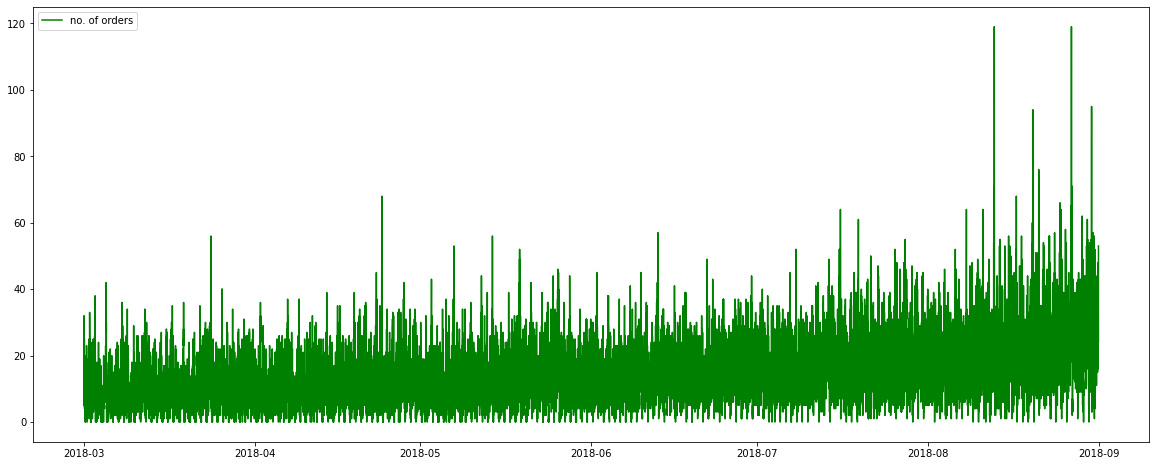

In [ ]:
chart_fig(df)

As we are interested in total order per hour.So we have to perform resampling by one hour, and aggregate value by sum.

In [ ]:
df_resample = df.resample('1H').sum()

In [ ]:
df_resample

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


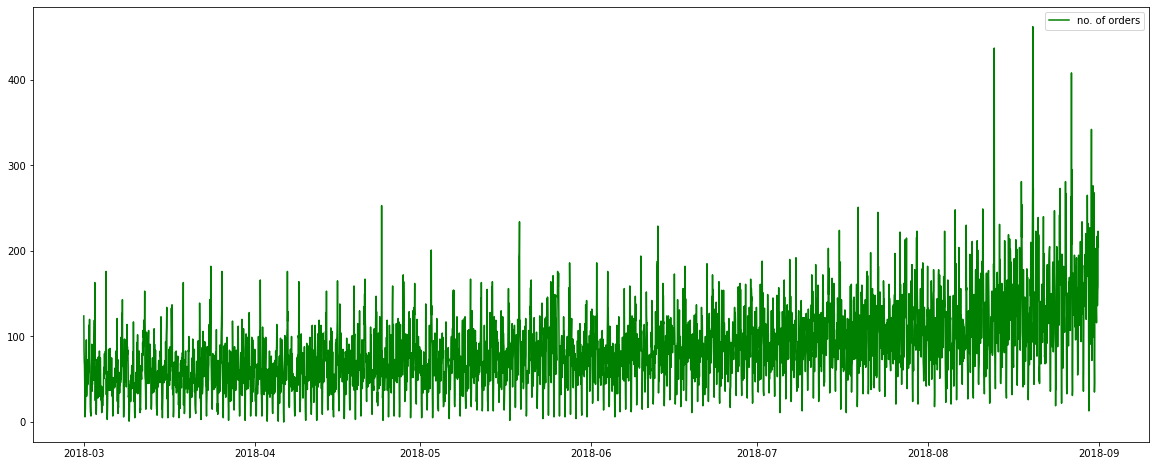

In [ ]:
chart_fig(df_resample)

In the loaded data, indexes are converted to DatetimeIndex objects, the date column is removed.
Resampling by one hour was performed with aggregation by the average - the density of the graph has slightly decreased, you can even visually trace the trend (roughly).

 # 2. Data analysis 
Since this is a time series, you can try to determine the trend and seasonality. First, let's plot the moving average on the resulting chart:

In [ ]:
# we have a resampling step of 1 hour, let's choose a window size of 24 (one day)
def plot_roll(df):
    chart_fig(df)
    plt.plot(df.rolling(24).mean(),'r', label='MOVING AVERAGES')
    plt.legend();

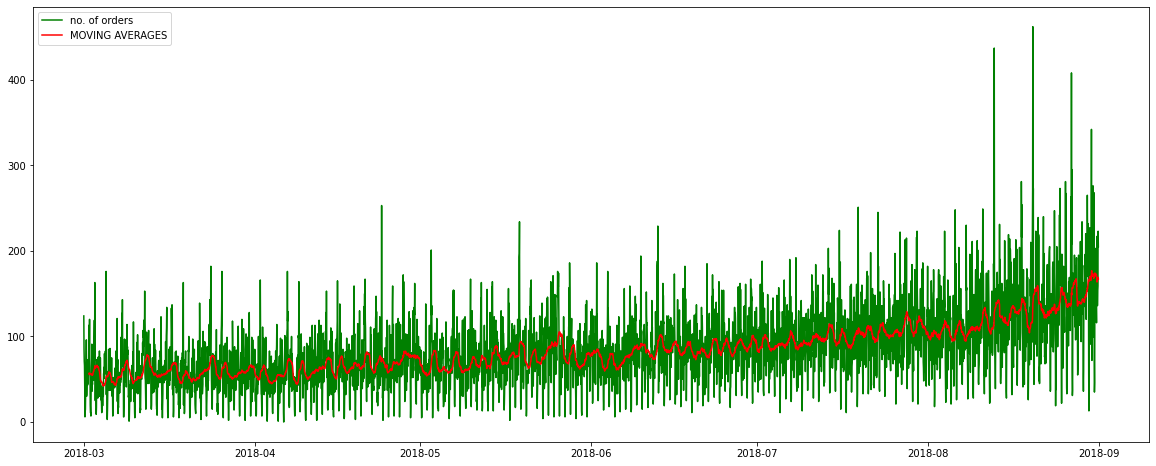

In [ ]:
plot_roll(df_resample)

In [ ]:
df_resample.head(60)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Every day there are some peak values ​​for orders. Let's take an interval of 1 week and 1 day, for example, in April and look at the data

In [ ]:
#1 week interval
df_week = df_resample['2018-07-09':'2018-07-16']

# 1 day interval
df_day = df_resample['2018-08-09':'2018-08-10']

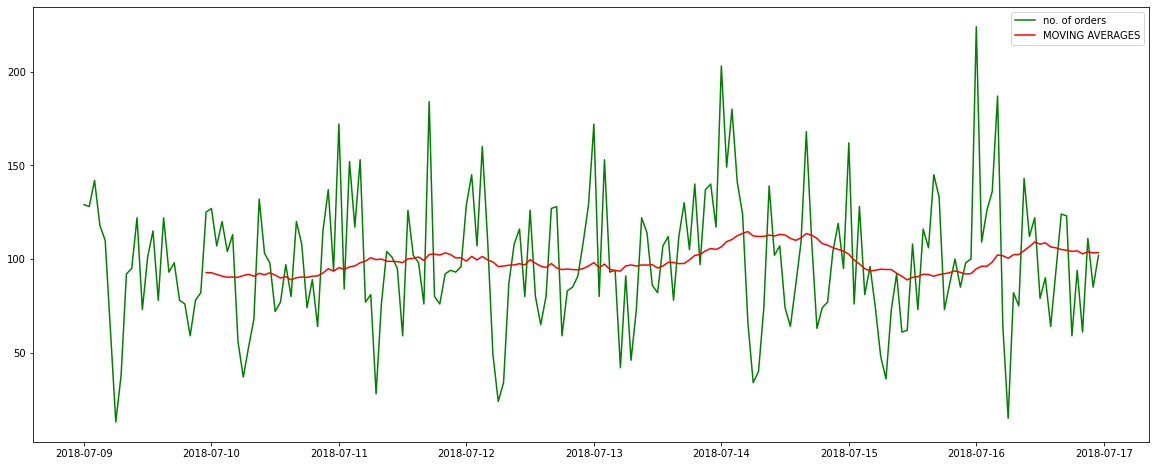

In [ ]:
plot_roll(df_week)

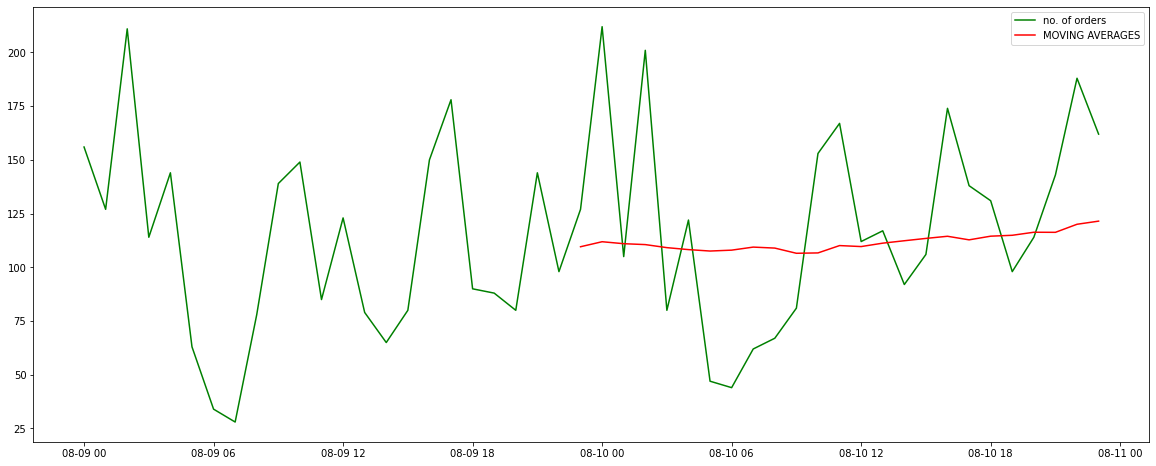

In [ ]:
plot_roll(df_day)

The peak of orders are at midnight.

The minimum orders are from 4 to 6 in the morning, and from 6 AM in the morning there is a sharp increase in orders(as people travel to their work location)
During the day, the number of orders fluctuates within a certain value without serious outliers.

Let's decompose the series into parts using the seasonal_decompose of the statsmodels module, using data for 1 month:

In [ ]:
decomposed = seasonal_decompose(df_week)


Let's display the trend, seasonality and transformation residuals:

In [ ]:
def plot_decompose(decomposed):
    plt.figure(figsize=(14, 16))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Remain Transformations')
    plt.subplots_adjust(hspace=0.5)

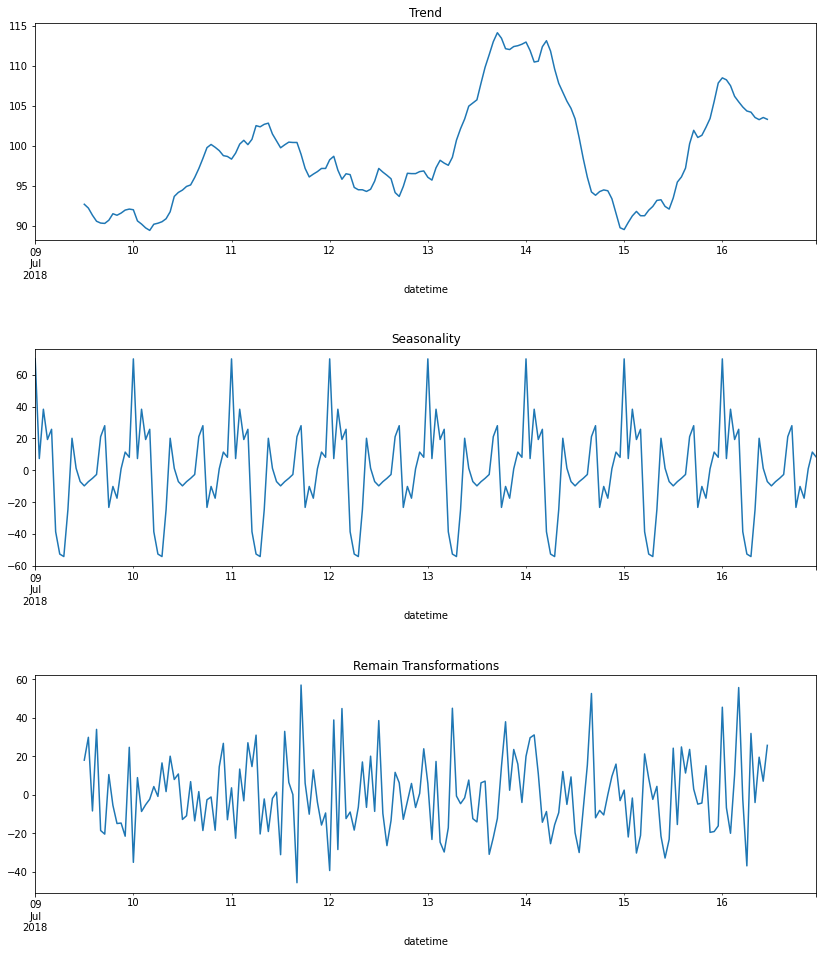

In [ ]:
plot_decompose(decomposed)

The number of orders during the week rises until midnight on Saturday, drops sharply on Sunday, and begins to rise again from Monday.

The seasonality chart clearly shows the cyclical daily changes in the number of orders.

Let's find the moving standard deviation for the data and show it on the chart.

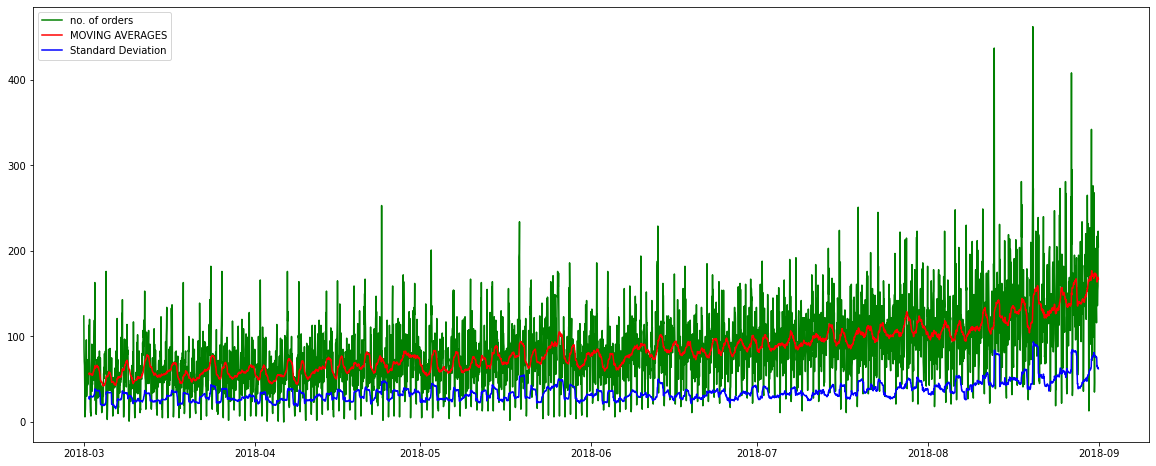

In [ ]:
plot_roll(df_resample)
plt.plot(df_resample.rolling(24).std(), 'b', label='Standard Deviation')
plt.legend();

From this graph, it can be seen that the mean and standard deviation increase with time, but it is not clear whether the series is stationary or not. To check the series for stationarity, we find the difference between its values.

In [ ]:
df_stat = df_resample['num_orders'] - df_resample['num_orders'].shift(fill_value=0)

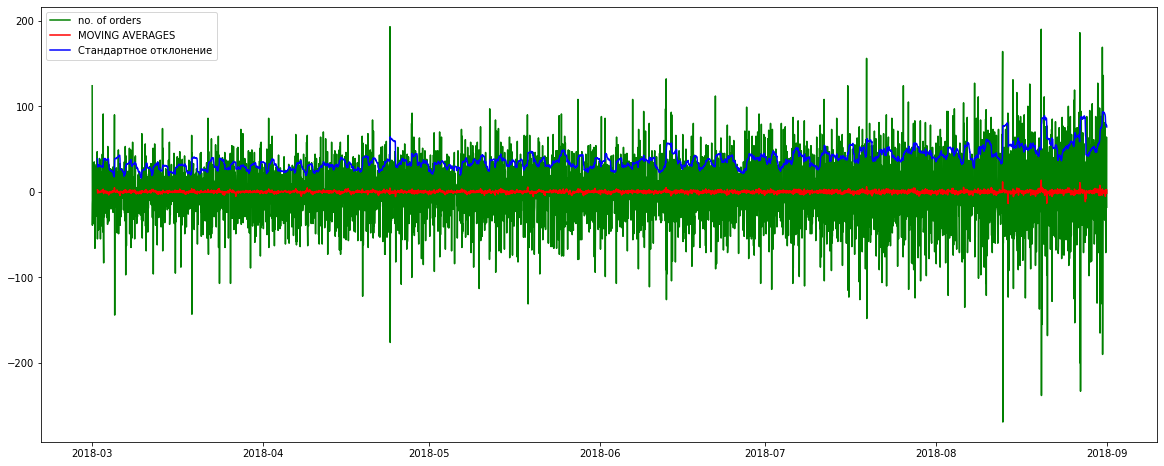

In [ ]:
plot_roll(df_stat)
plt.plot(df_stat.rolling(24).std(), 'b', label='Стандартное отклонение')
plt.legend();

The mean does not change now - the series has become stationary => it can be predicted.

# 3. Preparing and training models
Now we need to generate new features. Let's add features with different shifts, calendar features and a moving average:

In [ ]:
def get_new_features(data, max_lag, roll_1, roll_2):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    data['rolling_mean_1'] = data['num_orders'].shift().rolling(roll_1).mean()
    data['rolling_mean_2'] = data['num_orders'].shift().rolling(roll_2).mean()
    data.dropna(inplace=True)

Let's copy df_resample into a new variable, which we will transform:

In [ ]:
df = df_resample.copy()

Create new features and remove all gaps:

In [ ]:
get_new_features(df, 15, 12, 24)

In [ ]:
df.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean_1,rolling_mean_2
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,56.583333,56.833333
2018-03-02 01:00:00,120,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,61.583333,55.416667
2018-03-02 02:00:00,75,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,68.916667,56.875000
2018-03-02 03:00:00,64,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,71.166667,57.041667
2018-03-02 04:00:00,20,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,...,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,71.000000,56.958333


Divide the dataset into test and training samples:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('num_orders', axis=1), df['num_orders'],
                                                    shuffle=False, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3952, 21), (3952,), (440, 21), (440,))


Let's choose classical models - linear regression, random forest and boosted model (let's try catboost). We will also check the model for adequacy by comparing the results with a model that will predict the median value.

Let's create models and check the error. Also, for clarity, we plot the obtained predictions on the graph:

In [ ]:
# a random model that predicts the median value
model_dummy = DummyRegressor(strategy='median')

# linear regression model
model_reg = LinearRegression()

# random forest model
model_rf = RandomForestRegressor(random_state=42)

# catboost
model_cat = CatBoostRegressor(silent=True, random_state=42)

Let's create a function that will calculate the RMSE metric, by which we will evaluate the quality of predictions:

In [ ]:
def rmse(y_true, predict):
    return mean_squared_error(y_true, predict) ** 0.5

Let's add a function for training and evaluating the quality of models:

In [ ]:
def model_train(model, name):
    print('-' * 12, f'Model {name}', '-' * 12)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print(f'RMSE on test data is: {rmse(y_test, predict)}')
    print('-' * 50)
    print()
    plt.figure(figsize=(16, 8))
    plt.plot(y_train, label='Training Data')
    plt.plot(y_test, 'g', label='Real data', alpha=0.5)
    plt.plot(pd.Series(predict, index=y_test.index), 'r', label='Predicted Values', alpha=0.8)    
    plt.title(name, fontsize=16)
    plt.legend()    
    plt.show()
    print('\n\n\n')
    print('*' * 50)

------------ Model Random Model ------------
RMSE on test data is: 87.21093811714634
--------------------------------------------------



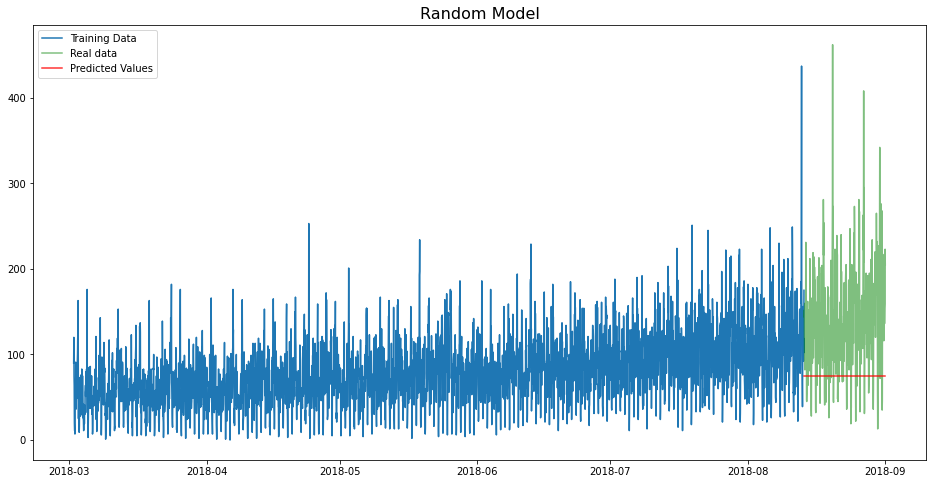





**************************************************
------------ Model Linear Regression ------------
RMSE on test data is: 50.57490683773931
--------------------------------------------------



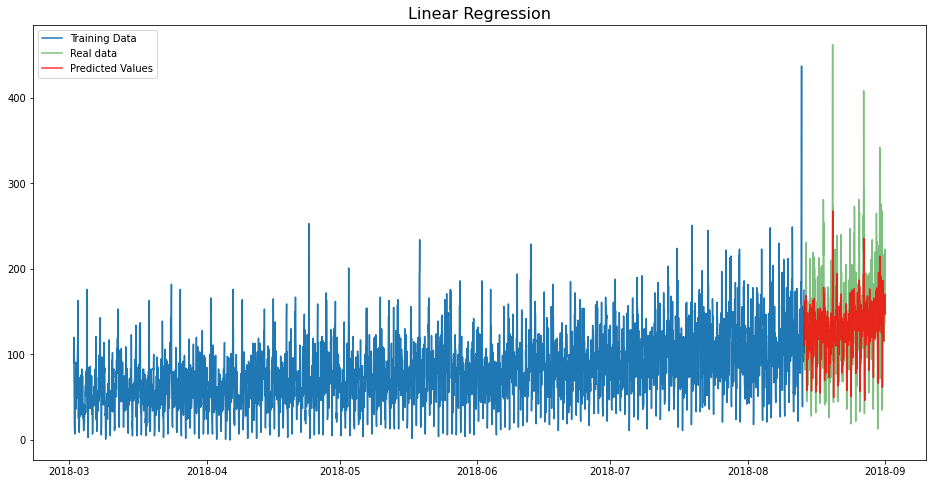





**************************************************
------------ Model Random Forest ------------
RMSE on test data is: 51.98353469871712
--------------------------------------------------



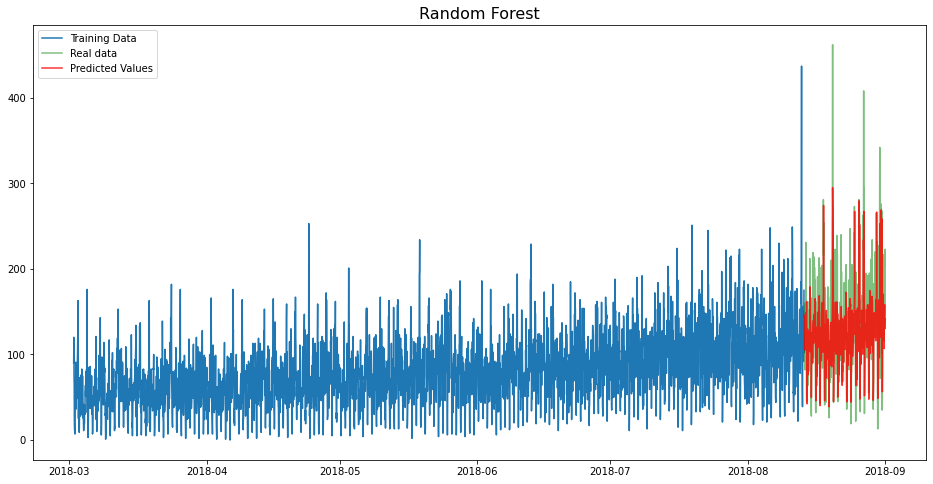





**************************************************
------------ Model Booster ------------
RMSE on test data is: 47.98120806895215
--------------------------------------------------



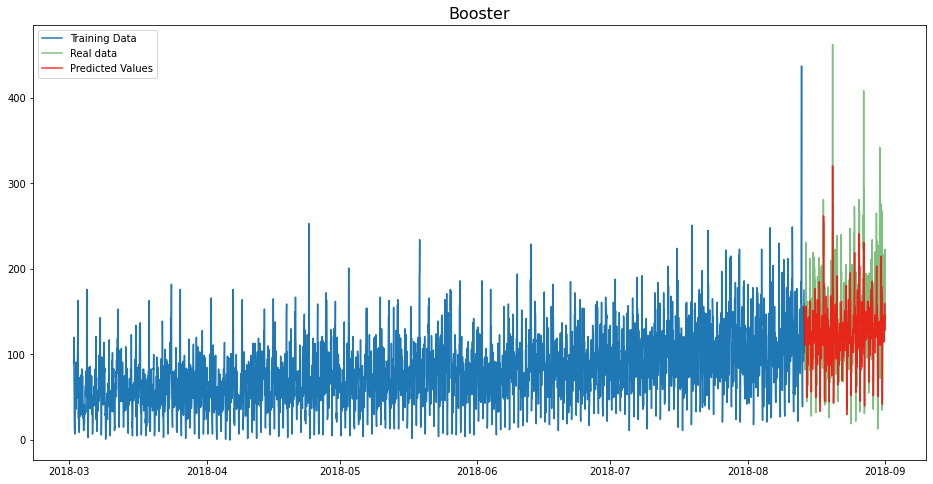





**************************************************


In [ ]:
for i in ((model_dummy, 'Random Model'), 
          (model_reg, 'Linear Regression'), 
          (model_rf, 'Random Forest'), 
          (model_cat, 'Booster')): 
    model_train(i[0], i[1])

Without hyperparameter fitting, the best model is the CatBoost model.

The random model gives the worst result.

The RMSE values ​​obtained from the results of the predictions do not satisfy the purpose of the project - let's select the hyperparameters of the Catboost booster and the decision tree.

The selection of parameters must be carried out using cross-validation.

# 4. Hyperparameter fitting 
Let's set the parameters for the booster and the random forest model.

In [ ]:
param_forest = {
    'n_estimators': range(10, 100, 10),
    'max_depth': range(3, 9), 
    'min_samples_leaf': range(3, 8),
}

param_cat = {
    'depth': range(3, 8)
}

Create a learning metric:


In [ ]:
rmse_score = make_scorer(rmse, greater_is_better=False)

In [ ]:
grid_forest = GridSearchCV(model_rf, param_forest, scoring=rmse_score, verbose=10, cv=3)
grid_cat = GridSearchCV(model_cat, param_cat, scoring=rmse_score, verbose=10, cv=3)

In [ ]:
%%time
for i in (grid_forest, grid_cat):
    i.fit(X_train, y_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
[CV 1/3; 1/270] START max_depth=3, min_samples_leaf=3, n_estimators=10..........
[CV 1/3; 1/270] END max_depth=3, min_samples_leaf=3, n_estimators=10;, score=-28.841 total time=   0.2s
[CV 2/3; 1/270] START max_depth=3, min_samples_leaf=3, n_estimators=10..........
[CV 2/3; 1/270] END max_depth=3, min_samples_leaf=3, n_estimators=10;, score=-30.088 total time=   0.2s
[CV 3/3; 1/270] START max_depth=3, min_samples_leaf=3, n_estimators=10..........
[CV 3/3; 1/270] END max_depth=3, min_samples_leaf=3, n_estimators=10;, score=-39.256 total time=   0.2s
[CV 1/3; 2/270] START max_depth=3, min_samples_leaf=3, n_estimators=20..........
[CV 1/3; 2/270] END max_depth=3, min_samples_leaf=3, n_estimators=20;, score=-28.904 total time=   0.3s
[CV 2/3; 2/270] START max_depth=3, min_samples_leaf=3, n_estimators=20..........
[CV 2/3; 2/270] END max_depth=3, min_samples_leaf=3, n_estimators=20;, score=-30.145 total time=   0.2s
[CV 3/3; 2/2

In [ ]:
grid_forest.best_params_

{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 90}

In [ ]:
grid_cat.best_params_

{'depth': 6}

Let's look at the results

------------ Model Random Forest ------------
RMSE on test data is: 51.67594816323439
--------------------------------------------------



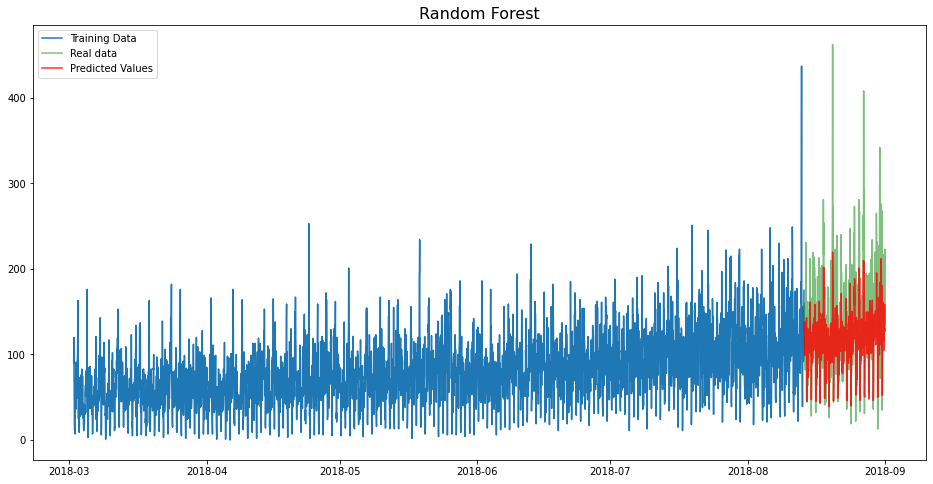





**************************************************


In [ ]:
model_train(grid_forest.best_estimator_, 'Random Forest')

------------ Model Catboost model ------------
RMSE on test data is: 47.98120806895215
--------------------------------------------------



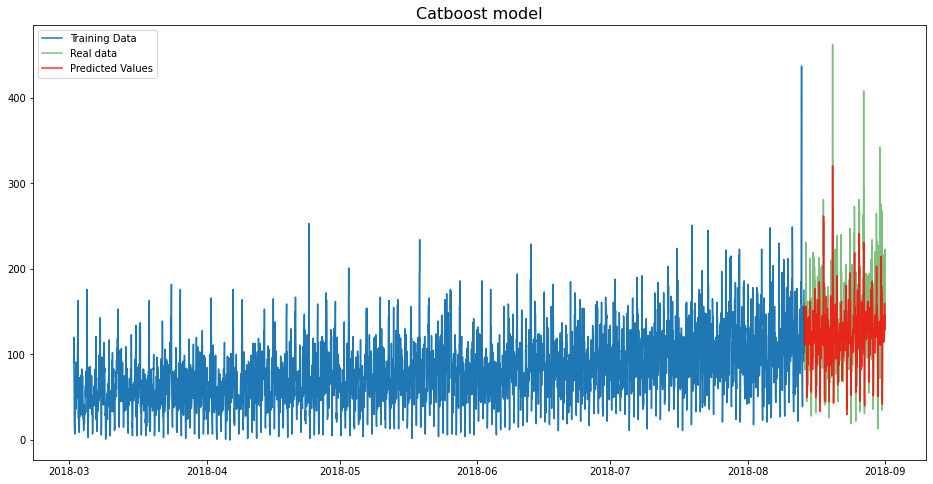





**************************************************


In [ ]:
model_train(grid_cat.best_estimator_, 'Catboost model')

The quality of CatBoost predictions is still better - we will select some more parameters only for it.

In [ ]:
param_cat_2 = {
    'depth': [6, 7],
    'l2_leaf_reg': [1.1],
    'learning_rate': [0.03],
    'iterations': [5000, 6000]
}

In [ ]:
grid_cat_2 = GridSearchCV(model_cat, param_cat_2, scoring=rmse_score, verbose=10, cv=3)

In [ ]:
%%time
grid_cat_2.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03
[CV 1/3; 1/4] END depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03;, score=-27.752 total time=  23.2s
[CV 2/3; 1/4] START depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03
[CV 2/3; 1/4] END depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03;, score=-25.900 total time=  23.2s
[CV 3/3; 1/4] START depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03
[CV 3/3; 1/4] END depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03;, score=-35.677 total time=  20.7s
[CV 1/3; 2/4] START depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03
[CV 1/3; 2/4] END depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03;, score=-27.782 total time=  27.6s
[CV 2/3; 2/4] START depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03
[CV 2/3; 2/4] END depth=6, iterations=6000, l2_leaf_reg=1.1, learning_

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa39f431e20>,
             param_grid={'depth': [6, 7], 'iterations': [5000, 6000],
                         'l2_leaf_reg': [1.1], 'learning_rate': [0.03]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=10)

In [ ]:
grid_cat_2.best_params_

{'depth': 7, 'iterations': 5000, 'l2_leaf_reg': 1.1, 'learning_rate': 0.03}

------------ Model Catboost model ------------
RMSE on test data is: 47.98268454325604
--------------------------------------------------



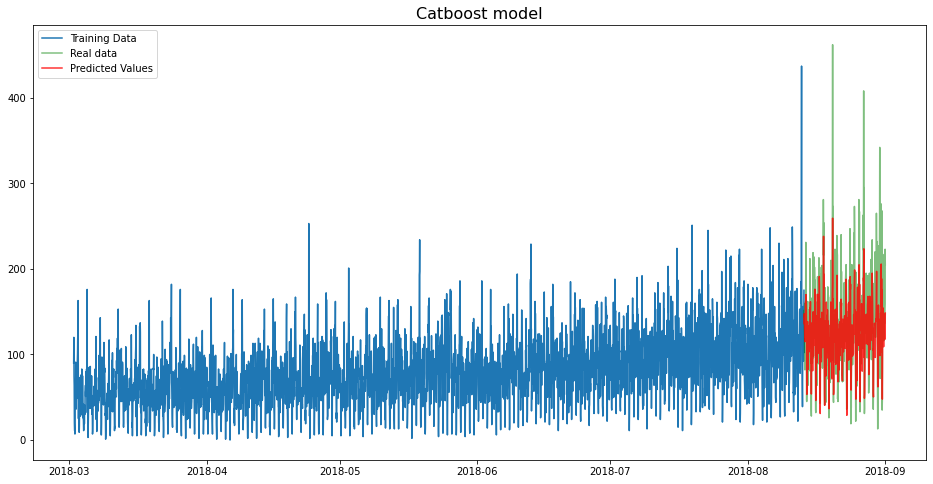





**************************************************


In [ ]:
model_train(grid_cat_2.best_estimator_, 'Catboost model')

# Conclusion 
During the project, 4 different models were analyzed and the following RMSE results were obtained on a test sample:
Random Model = 87.2 
Linear regression = 50.57

# After tuning the hyperparameters: 
Random Forest = 51.7 
Model using gradient boosting (CatBoost) = 47.98

The goal of the project is fulfilled, a model with a value of RMSE < 48 is obtained - CatBoost model

In [ ]:
# copy the original dataset 
df_for_lin = df_resample.copy()

In [ ]:
get_new_features(df_for_lin, 25, 12, 24)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_for_lin.drop('num_orders', axis=1), df_for_lin['num_orders'],
                                                    shuffle=False, test_size=0.1, random_state=42)

RMSE on test data is: 45.68738572668911
--------------------------------------------------



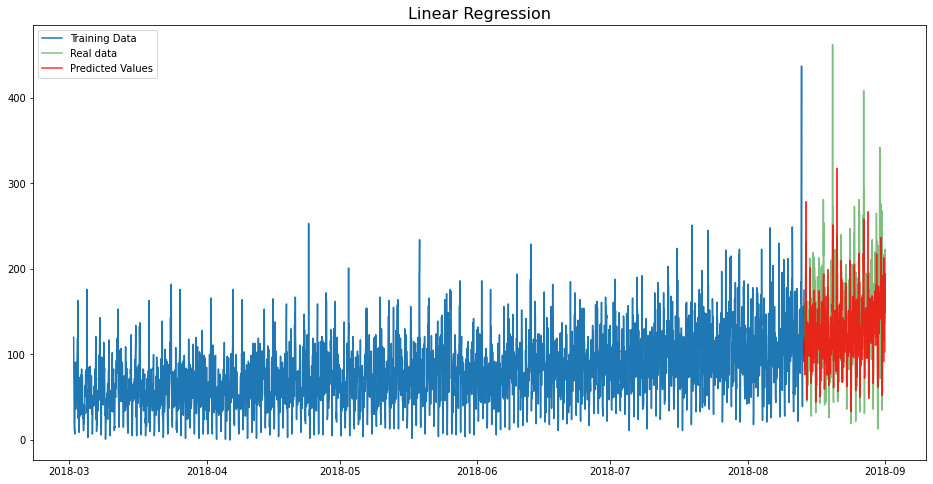

In [ ]:
# train the model and plot
model_reg.fit(X_train, y_train) 
predict = model_reg.predict(X_test) 
print(f'RMSE on test data is: {rmse(y_test, predict)}')
print('-' * 50) 
print()
plt.figure(figsize=(16, 8)) 
plt.plot(y_train, label='Training Data')
plt.plot(y_test, 'g', label='Real data', alpha=0.5) 
plt.plot(pd.Series(predict, index=y_test.index), 'r', label='Predicted Values', alpha=0.8) 
plt.title('Linear Regression', fontsize=16) 
plt.legend();

# Conclusion 
With a sufficiently large number of features created, the linear regression model satisfies the project goal - its RMSE = 45.7 < 48.